### Updating the Iron Cycle

We have updates from UCI that do the following:

1. Change the process for generating iron sediment fluxes
2. Adds a dust production term that feeds into the iron cycle
3. Includes variable N:C stochiometry

We are noticing linear decreases in iron stores in some parts of the deep ocean
(in both vanishingly thin layers and thicker layers above them).
These decreases do not level off, causing iron to eventually go negative.

Keith L. found that setting `dust%prod = 0.` prevents negative iron.
`dust%prod` is computed from iron sediment and vent fluxes,
and Keith M. suggested decreasing some of the parameters involved in that computation.

In [1]:
import glob
import os

from matplotlib import pyplot as plt
import nc_time_axis
import numpy as np
import xarray as xr

In [2]:
scratch_root = os.path.join(os.path.sep,
                            'glade',
                            'derecho',
                            'scratch',
                            'mlevy')

In [3]:
case_dict = {}
case_dict['old fesedflux'] = {'case_name': 'g.e30b06.GW1850MARBL_JRA.old_fesedflux',
                              'nyears': 20,
                              'archived': True}

case_dict['new fesedflux'] = {'case_name': 'g.e30b06.GW1850MARBL_JRA.new_fesedflux.002',
                              'nyears': 20,
                              'archived': True}

case_dict['1/10 dustprod'] = {'case_name': 'g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_klindsay_dustprod.lessprod',
                              'nyears': 11,
                              'archived': False}

case_dict['1/30 dustprod'] = {'case_name': 'g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_klindsay_dustprod.even_lessprod',
                              'nyears': 18,
                              'archived': True}

case_dict['zero dustprod'] = {'case_name': 'g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_no_dustprod',
                              'nyears': 9,
                              'archived': True}

In [4]:
xh = []
yh = []
z_l = []
plot_titles = []

### Random point near Indonesia that stood out for having negative Fe
plot_titles.append('Point in W Equatorial Pacific (depth=4500m)')
xh.append(108) # longitude: -214.66667 E
yh.append(262) # latitude: 1.9989178 N
z_l.append(30) # depth: 4500 m

### Point where Fe is at a [large negative] minimum in 'less dustprod'
plot_titles.append('Point with negative Fe using (990,9.9) param values (depth=5500m)')
xh.append(404) # longitude: -17.274424 E
yh.append(346) # latitude 38.21328 N
z_l.append(32) # depth: 5500 m

### Point where Fe is at a [large negative] minimum in 'new fesedflux'
plot_titles.append('Point with negative Fe using (9900,99) param values (depth=5500m)')
xh.append(409) # longitude: 62.18253 E
yh.append(477) # latitude 86.34934 N
z_l.append(28) # depth: 3500 m

In [5]:
vars = ['Fe', 'P_iron_REMIN']

def create_ds_dict(case_dict):
    ds_dict = {}
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    for desc, case_details in case_dict.items():
        if case_details['archived']:
            case_output_dir = os.path.join(scratch_root,
                                           'archive',
                                           case_details['case_name'],
                                           'ocn',
                                           'hist')
        else:
            case_output_dir = os.path.join(scratch_root,
                                           case_details['case_name'],
                                           'run')
        file_list = []
        for year in range(case_details['nyears']):
            file_list = file_list + list(glob.glob(os.path.join(case_output_dir,f'{case_details["case_name"]}.mom6.h.bgc.z.{year+1:04d}*.nc')))
        print(f'Creating dataset for {case_details["case_name"]}')
        ds = xr.open_mfdataset(file_list, data_vars=vars, compat='override', join='override', coords='minimal', decode_times=time_coder, decode_timedelta=False)
        ds_dict[desc] = ds
    return ds_dict


def compute_timeseries_at_point(ds, xh, yh, z_l):
    return ds[['Fe', 'P_iron_REMIN']].isel(xh=xh, yh=yh, z_l=z_l).compute()

def compute_global_Fe_integral(ds):
    return (ds['Fe'] * ds['volcello']).sum(['xh', 'yh', 'z_l']).compute()

In [6]:
%%time
ds_dict = create_ds_dict(case_dict)

Creating dataset for g.e30b06.GW1850MARBL_JRA.old_fesedflux
Creating dataset for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002
Creating dataset for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_klindsay_dustprod.lessprod
Creating dataset for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_klindsay_dustprod.even_lessprod
Creating dataset for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_no_dustprod
CPU times: user 1min 31s, sys: 5.67 s, total: 1min 37s
Wall time: 2min 26s


In [7]:
%%time
da_Fe_int_dict = {}
for desc, ds in ds_dict.items():
    print(f'* Computing global iron integral for {case_dict[desc]["case_name"]}')
    da_Fe_int_dict[desc] = compute_global_Fe_integral(ds_dict[desc])

* Computing global iron integral for g.e30b06.GW1850MARBL_JRA.old_fesedflux
* Computing global iron integral for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002
* Computing global iron integral for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_klindsay_dustprod.lessprod
* Computing global iron integral for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_klindsay_dustprod.even_lessprod
* Computing global iron integral for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_no_dustprod
CPU times: user 1min 22s, sys: 1min 52s, total: 3min 15s
Wall time: 5min 33s


In [9]:
%%time
ds_pt_dict = {key: [] for key in ds_dict.keys()}
for n in range(len(xh)):
    print(f'Creating data sets with xh={xh[n]}, yh={yh[n]}, and z_l={z_l[n]}')
    for desc, ds in ds_dict.items():
        print(f'* Creating data set for {case_dict[desc]["case_name"]}')
        ds_pt_dict[desc].append(compute_timeseries_at_point(ds, xh[n], yh[n], z_l[n]))

Creating data sets with xh=108, yh=262, and z_l=30
* Creating data set for g.e30b06.GW1850MARBL_JRA.old_fesedflux
* Creating data set for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002
* Creating data set for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_klindsay_dustprod.lessprod
* Creating data set for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_klindsay_dustprod.even_lessprod
* Creating data set for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_no_dustprod
Creating data sets with xh=404, yh=346, and z_l=32
* Creating data set for g.e30b06.GW1850MARBL_JRA.old_fesedflux
* Creating data set for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002
* Creating data set for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_klindsay_dustprod.lessprod
* Creating data set for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_klindsay_dustprod.even_lessprod
* Creating data set for g.e30b06.GW1850MARBL_JRA.new_fesedflux.002betterLig_and_no_dustprod
Creating data se

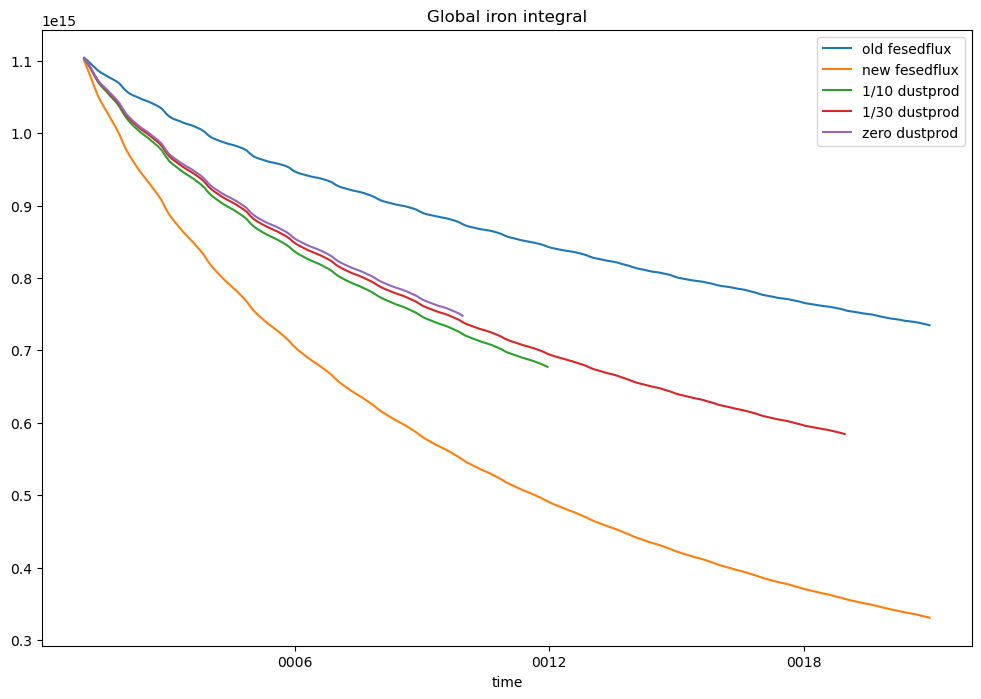

In [8]:
plt.figure(figsize=[12,8])
for da in da_Fe_int_dict.values():
    da.plot()
    plt.title('Global iron integral')
plt.legend(da_Fe_int_dict.keys())
plt.show()

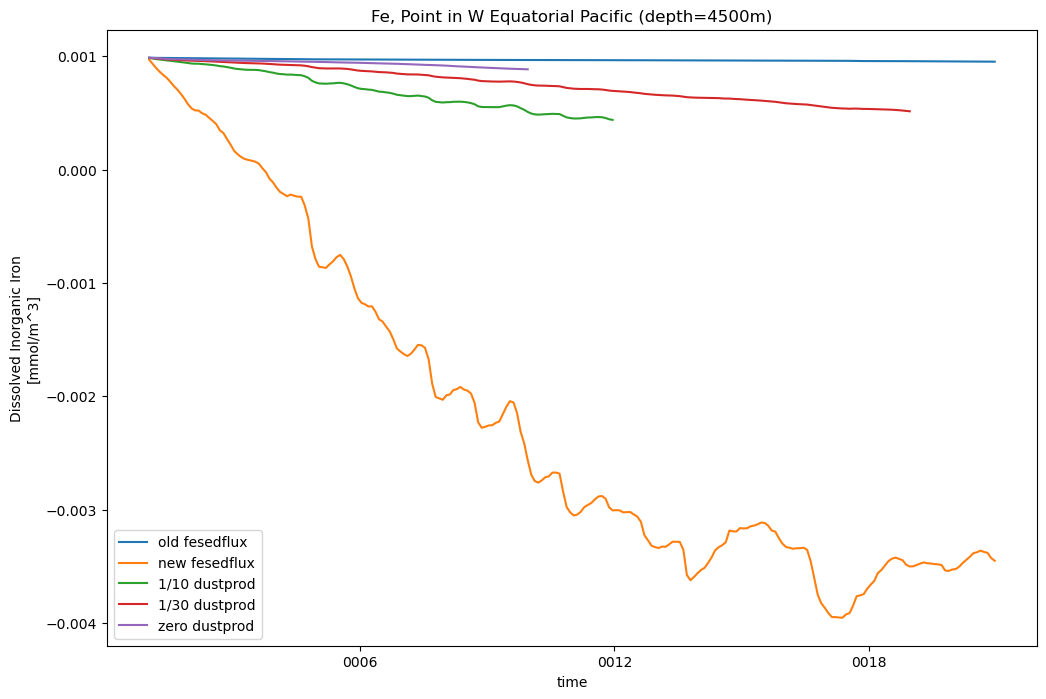

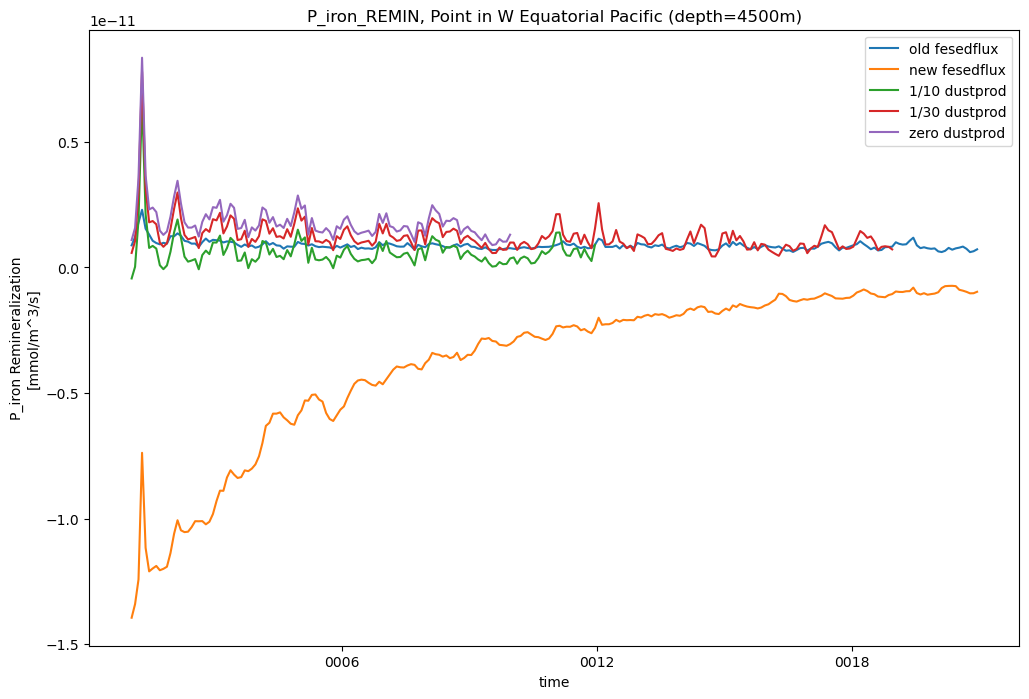

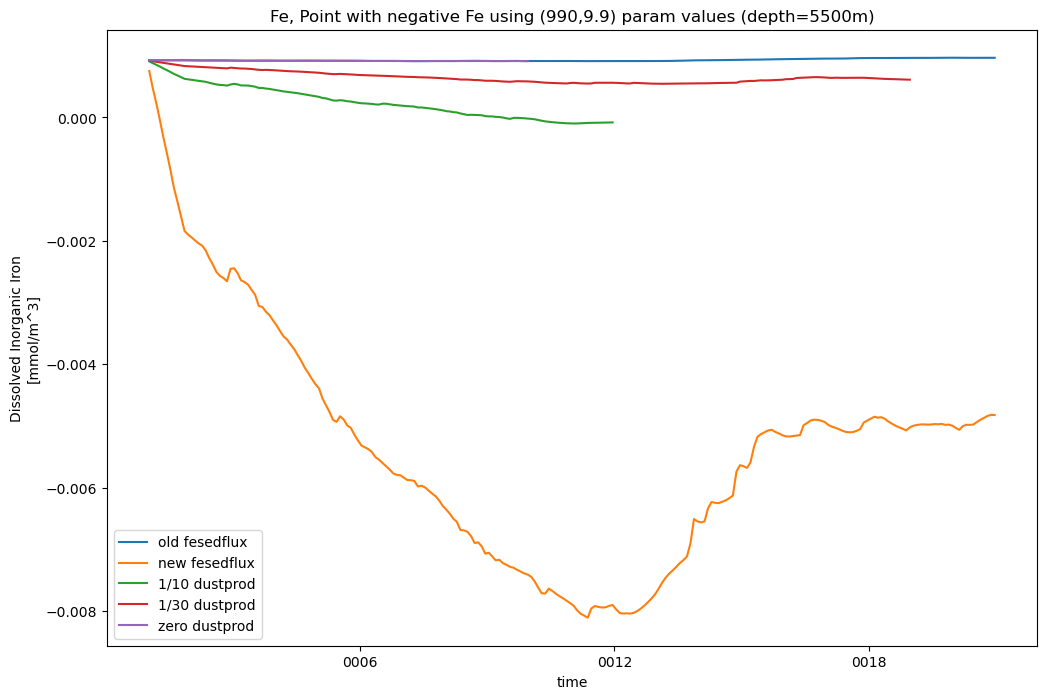

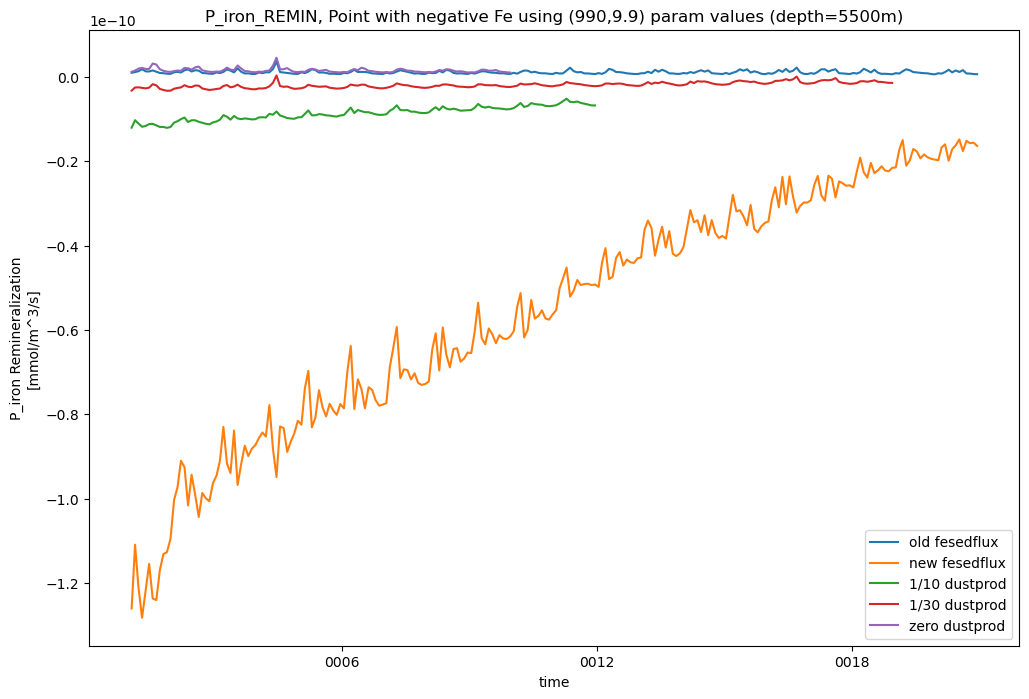

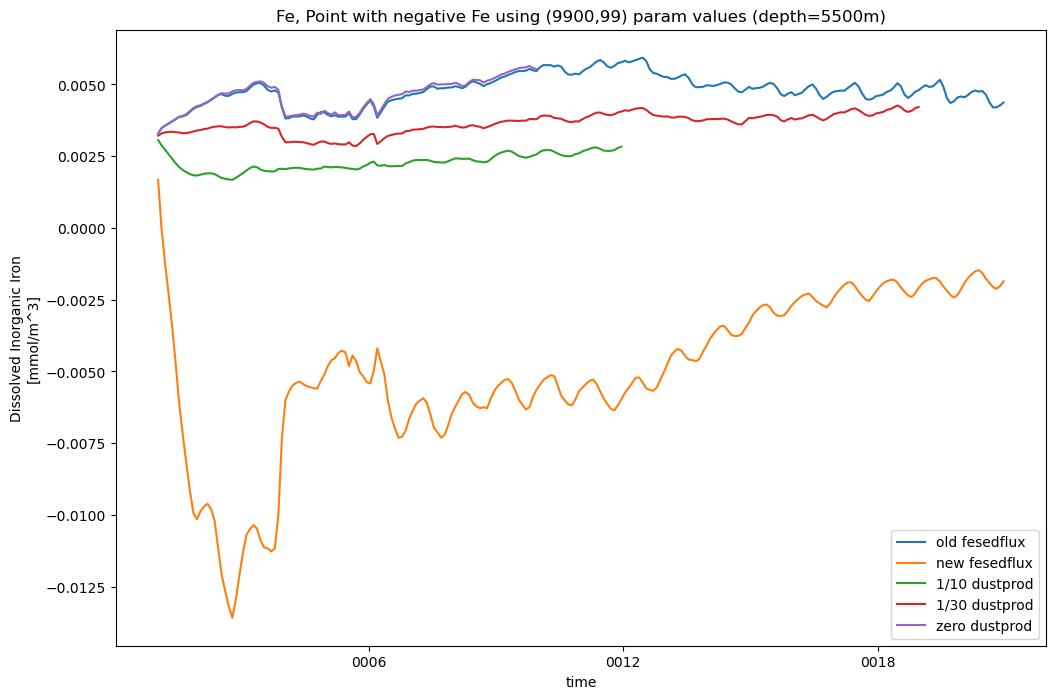

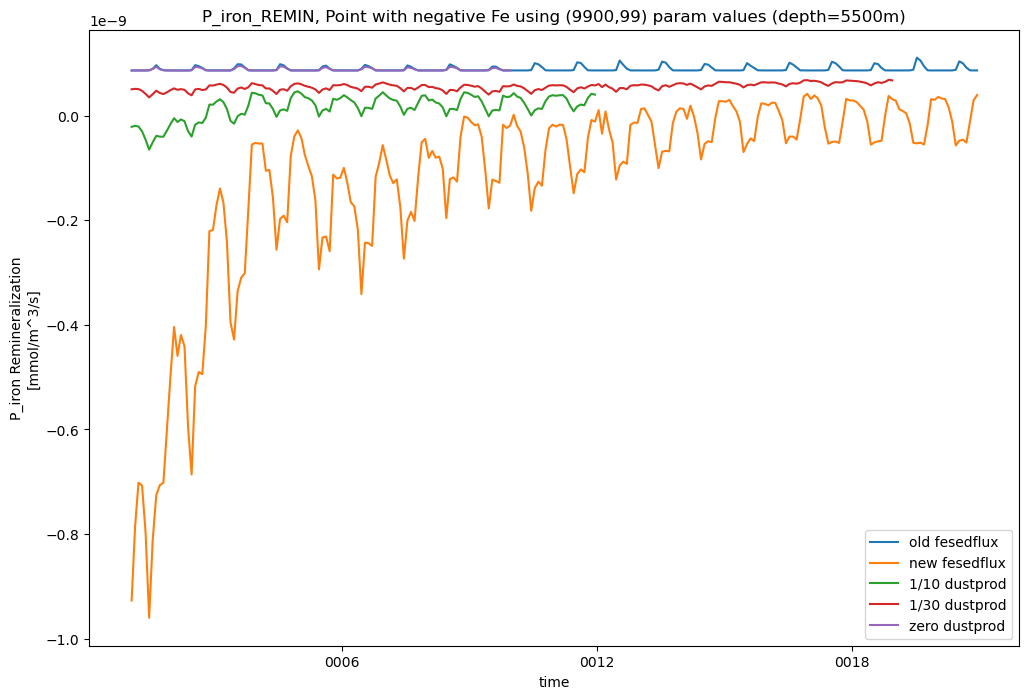

In [10]:
for n in range(len(xh)):
    for var in vars:
        plt.figure(figsize=[12,8])
        for ds in ds_pt_dict.values():
            ds[n][var].plot()
            plt.title(f'{var}, {plot_titles[n]}')
            # plt.ylim((0,0.001))
        plt.legend(ds_pt_dict.keys())
        plt.show()